<a href="https://colab.research.google.com/github/ketanpandey01/Bears-Classification/blob/master/Bear_Classification_using_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Utilities
import sys
import tarfile
from six.moves import urllib
import os
import time

# Data Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

# Data manipulation
from random import sample
import numpy as np
from collections import defaultdict

# Image Processing
from skimage.transform import resize

# Get Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
BEARS_IMAGES_ZIP = "/content/drive/My Drive/Datasets/bear_photos.tar.xz"
BEARS_IMAGES_PATH = os.path.join("/content/drive/My Drive/Colab Notebooks/","datasets", "bears")

def fetch_bears(tgz_path=BEARS_IMAGES_ZIP, path=BEARS_IMAGES_PATH):
    if os.path.exists(BEARS_IMAGES_PATH):
      print("Data already loaded")
      return
    os.makedirs(path, exist_ok=True)
    bears_tgz = tarfile.open(tgz_path)
    bears_tgz.extractall(path=path)
    bears_tgz.close()
    #os.remove(tgz_path)

In [4]:
fetch_bears()

Data already loaded


# Data Pre-Processing

## Getting the list of classes

In [5]:
bears_root_path = os.path.join(BEARS_IMAGES_PATH, "bear_photos")
bears_classes = sorted([dirname for dirname in os.listdir(bears_root_path)
                  if os.path.isdir(os.path.join(bears_root_path, dirname))])
bears_classes

['Grizzly', 'Panda', 'Polar']

## Getting the list of all the image file paths for each class

In [0]:
image_paths = defaultdict(list)

for bear_class in bears_classes:
    image_dir = os.path.join(bears_root_path, bear_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[bear_class].append(os.path.join(image_dir, filepath))

In [7]:
print("No. of images in each class:")
print("Grizzly {}".format(len(image_paths['Grizzly'])))
print("Panda {}".format(len(image_paths['Panda'])))
print("Polar {}".format(len(image_paths['Polar'])))

No. of images in each class:
Grizzly 338
Panda 328
Polar 253


In [0]:
# Sort the image paths so that this notebook behaves consistently across multiple runs
for paths in image_paths.values():
    paths.sort()    

## Look at few images from each class

Class: Grizzly


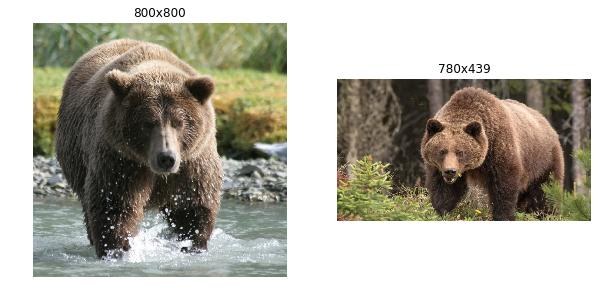

Class: Panda


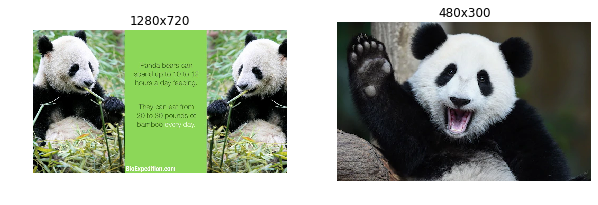

Class: Polar


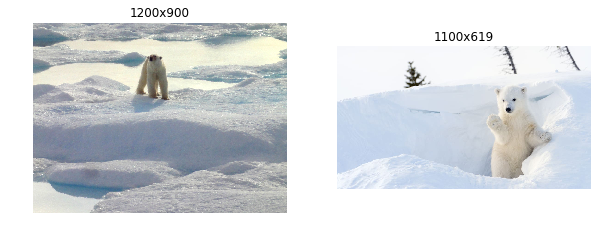

In [9]:
n_examples_per_class = 2

for bear_class in bears_classes:
    print("Class:", bear_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[bear_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :3]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

## Image Processing
This step that will resize and crop the image to 299 × 299, with some randomness for data augmentation.

In [0]:


def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    # The resize function of scikit-image will automatically transform the image to floats ranging from 0.0 to 1.0
    image = resize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as 32-bit floats:
    return image.astype(np.float32)

### Image before processing

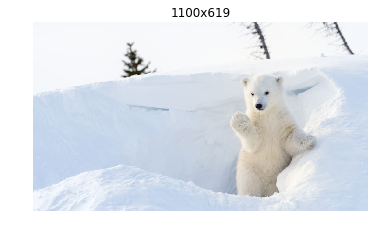

In [11]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

### Image after processing

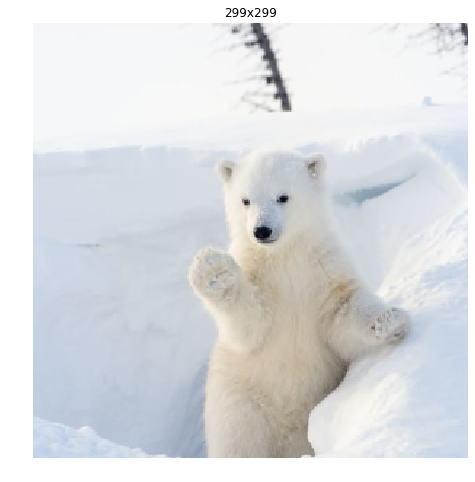

In [12]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

### Some random images generated from the same original image

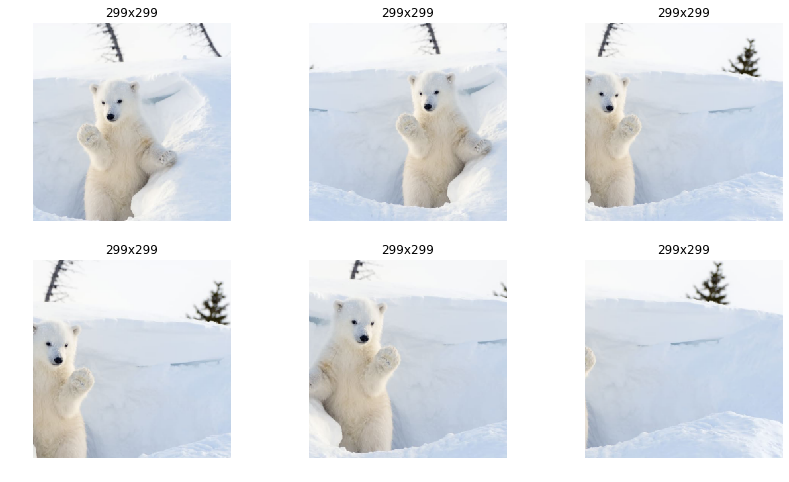

In [45]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

In [14]:
prepared_image.shape

(299, 299, 3)

# Split data into Train and Test set

## Convert the classes from string to integers.

In [15]:
bear_class_ids = {bear_class: index for index, bear_class in enumerate(bears_classes)}
bear_class_ids

{'Grizzly': 0, 'Panda': 1, 'Polar': 2}

## Represent data as list of (filepath, class) pairs

In [0]:
bear_paths_and_classes = []
for bear_class, paths in image_paths.items():
    for path in paths:
        bear_paths_and_classes.append((path, bear_class_ids[bear_class]))

In [0]:
# Splitting the data into train and test set. Dividing in 80:20 ratio.
test_ratio = 0.2
train_size = int(len(bear_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(bear_paths_and_classes)

bear_paths_and_classes_train = bear_paths_and_classes[:train_size]
bear_paths_and_classes_test = bear_paths_and_classes[train_size:]

In [18]:
bear_paths_and_classes_train[:3]

[('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Grizzly/149.Grizzly%20Bear%20resting.jpg',
  0),
 ('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Panda/65.panda-652469.jpg',
  1),
 ('/content/drive/My Drive/Colab Notebooks/datasets/bears/bear_photos/Grizzly/339.643757586.jpg',
  0)]

In [19]:
len(bear_paths_and_classes_train)

735

## Function to create batches of data during training and testing purposes.

In [0]:
def prepare_batch(bear_paths_and_classes, batch_size):
  batch_paths_and_classes = sample(bear_paths_and_classes, batch_size)
  
  X_batch = []
  y_batch = []
  corrupt_images = []
  prepared_images = []
  for path, labels in batch_paths_and_classes:
    image = mpimg.imread(path)
    if image.shape is ():
      corrupt_images.append(path)
    else:
      image = mpimg.imread(path)[:, :, :3]
      prepared_images.append(prepare_image(image))
      y_batch.append(labels)
  
  X_batch = 2 * np.stack(prepared_images) - 1
  y_batch = np.array(y_batch, dtype=np.int32)
  return X_batch, y_batch

In [0]:
X_batch, y_batch = prepare_batch(bear_paths_and_classes_train, batch_size=4)

In [22]:
X_batch[0].shape

(299, 299, 3)

In [23]:
X_batch[0].dtype

dtype('float32')

In [24]:
y_batch.shape

(4,)

In [25]:
y_batch.dtype

dtype('int32')

In [26]:
## Create test set
len(bear_paths_and_classes_test)

184

In [0]:
X_test, y_test = prepare_batch(bear_paths_and_classes_test, batch_size=len(bear_paths_and_classes_test))

In [28]:
len(X_test)

184

# Inception v3

Using the pretrained inception v3 model, freezing all the layers up to the bottleneck layer (i.e. the last layer before the output layer), and replace the output layer with the appropriate number of outputs for the new classification task (i.e. bears dataset has 3 mutually exclusive classes so the output layer must have three neurons and use the softmax activation function).

### Download the latest pre-trained Inception v3 model
### Checkpoint: https://github.com/tensorflow/models/tree/master/research/slim.

In [0]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("/content/drive/My Drive/Colab Notebooks/","datasets","inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        print("Model already downloaded")
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [30]:
fetch_pretrained_inception_v3()

Downloading: 100%

### Fetch the Inception v3 graph by calling the inception_v3() function

In [0]:
width = 299
height = 299
channels = 3

In [0]:
X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

### Find the layer just before the current output layer.

In [33]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [34]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

In [35]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

###  This is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon.

In [36]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

As you can see, the `"PreLogits"` end point is precisely what we need:

In [37]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

In [0]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer

In [39]:
n_outputs = len(bears_classes)

with tf.name_scope("new_output_layer"):
    bear_logits = tf.layers.dense(prelogits, n_outputs, name="bear_logits")
    Y_proba = tf.nn.softmax(bear_logits, name="Y_proba")

W0808 00:20:02.953619 139816764868480 deprecation.py:323] From <ipython-input-39-00a27d240e70>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0808 00:20:02.961607 139816764868480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

Since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method

In [0]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=bear_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    bear_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="bear_logits")
    training_op = optimizer.minimize(loss, var_list=bear_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(bear_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [41]:
[v.name for v in bear_vars]

['bear_logits/kernel:0', 'bear_logits/bias:0']

# Train the model
We are ready to train our network (or more precisely, the output layer we just added, since all the other layers are frozen). Using the 'Saver' to restore the pretrained model checkpoint we downloaded earlier

In [0]:
BEARS_MODEL_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "my_bears_model.ckpt")

In [47]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(bear_paths_and_classes_train) // batch_size
startTime = time.time()

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(bear_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Last batch accuracy:", acc_batch)

        save_path = saver.save(sess, BEARS_MODEL_CHECKPOINT_PATH)

endTime = time.time()
print("Time taken for training {}s".format(endTime-startTime))

W0808 00:26:49.943409 139816764868480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Epoch 0.................

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


.  Last batch accuracy: 0.975
Epoch 1..................  Last batch accuracy: 0.974359
Epoch 2..................  Last batch accuracy: 1.0
Epoch 3..................  Last batch accuracy: 1.0
Epoch 4..................  Last batch accuracy: 1.0
Epoch 5..................  Last batch accuracy: 1.0
Epoch 6..................  Last batch accuracy: 1.0
Epoch 7..................  Last batch accuracy: 1.0
Epoch 8..................  Last batch accuracy: 1.0
Epoch 9..................  Last batch accuracy: 0.975
Time taken for training 1455.7147872447968s


# Test the model

In [48]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, BEARS_MODEL_CHECKPOINT_PATH)

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    
    print('Test accuracy:',format(acc_test*100,'.2f'),'%')

Computing final accuracy on the test set (this will take a while)...
Test accuracy: 98.92 %


## Let's make predictions on a few random images

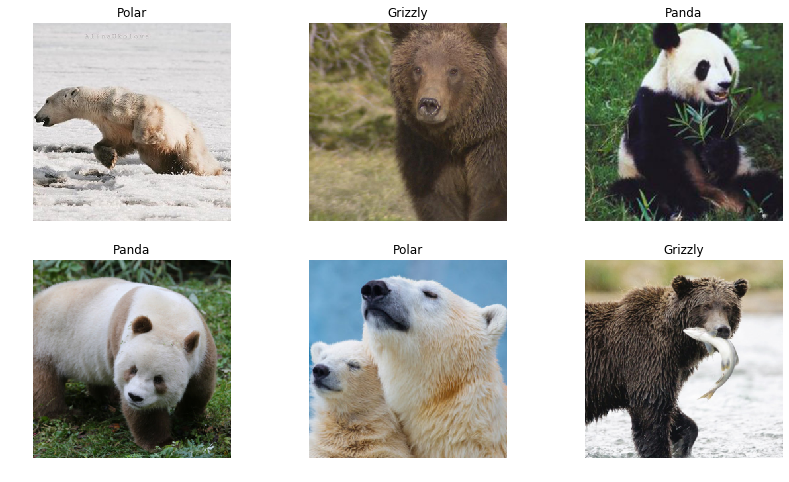

In [52]:
bear_class_dict = {0:'Grizzly', 1:'Panda', 2:'Polar'}
bear_predictions = []

for path, labels in sample(bear_paths_and_classes_test,6):
  image = mpimg.imread(path)[:, :, :3]
  prepared_image = prepare_image(image)
  show_image = prepared_image
  prepared_image = 2 * prepared_image - 1
  prepared_image = prepared_image.reshape(-1, height, width, channels)
  
  with tf.Session() as sess:
    saver.restore(sess, BEARS_MODEL_CHECKPOINT_PATH)
    predictions_val = Y_proba.eval(feed_dict={X: prepared_image})
    
  bear_predictions.append((show_image, np.argmax(predictions_val)))
    
rows, cols = 2, 3
count=0
plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = bear_predictions[count][0]
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}".format(bear_class_dict[bear_predictions[count][1]]))
        plt.imshow(prepared_image)
        plt.axis("off")
        count+=1
plt.show()
  